# Интеллектуальный анализ данных – весна 2025

# Домашнее задание 7: Деревья. Случайный лес

Правила:

- Домашнее задание оценивается в 10 баллов.


- Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.


- Можно использовать любые свободные источники с обязательным указанием ссылки на них.


- Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

<!-- ![](meme.jpg) -->
<img src="meme.jpg" alt="Drawing" style="width: 700px;"/>

## Часть 1: Основы построения решающие дерева (1.5 балла)

В этой части все расчёты необходимо реализовывать в виде запрограммированных формул, например, на `numpy`. **Нельзя использовать готовые реализации**. Например, если в задании требуется рассчитать энтропию, то требуется в каком-то виде релизовать расчёт по формуле, но нельзя использовать готовую реализацию `some_module.entropy()`.

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Задание 1.1 (0.5 балла)** Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 имеют метку класса $k_2$. Рассчитайте энтропию такого распределения классов (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

In [21]:
def entropy(y : np.ndarray) -> float:
    probs = np.unique(y, return_counts=True)[1] / len(y)
    return -np.sum(probs * np.log(probs))

In [22]:
ticks = np.array([1, 1, 1, 1, 1, 1, 1, 1, 0, 0])
print(f'Entropy: {entropy(ticks):.2f}')

Entropy: 0.50


**Задание 1.2 (0.5 балла)** Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности:

$$
Q(R_m, j, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$

где $R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения, $R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

Теперь в качестве $H(R)$ будем использовать индекс Джини:

$$
H(R) = \sum_{k=1}^J p_k(1-p_k),
$$
где $J$ – общее количество классов (в нашем случае, $J = 2$).

Ответ округлите до двух знаков после запятой.

In [23]:
def gini(y : np.ndarray) -> float:
    probs = np.unique(y, return_counts=True)[1] / y.size
    return np.sum(probs * (1 - probs))

In [24]:
def information_criterion(y : np.ndarray, left : np.ndarray, right : np.ndarray, imp_func : callable = gini) -> float:
    return imp_func(y) - left.size / y.size * imp_func(left) - right.size / y.size * imp_func(right) if y.size != 0 and left.size != 0 and right.size != 0 else 0.0

In [25]:
print(f'Information criterion: {information_criterion(ticks, ticks[:8], ticks[8:]):.2f}')

Information criterion: 0.32


**Задание 1.3 (0.5 балла)** Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

In [26]:
print(np.array([1, 10, 5, 18, 100, 30, 50, 61, 84, 47]).mean())

40.6


## Часть 2: Решающие деревья (4.5 балла)

В этой части мы напишем и протестируем собственную реализацию решающего дерева.

In [27]:
from collections import Counter
from typing import Dict, List, Tuple, Union

**Задание 2.1 (1.5 балла)** Реализуйте функцию `find_best_split()`, которая должна находить оптимальное разбиение подмножества обучающей выборки в соответствии с информационным критерием из **Задания 1.2**. В качестве меры хаотичности $H(R)$ для задачи регрессии испольуйте дисперсию подвыборки, а для задачи классификации – критерий Джини (определён в том же задании).

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. Подробнее об этом можно прочитать в конспектах [лекций](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf) по машинному обучению на ПМИ (раздел «Учёт категориальных признаков»).

В качестве подсказок реализации можете пользоваться кодом из бонусной части семинара по решающим деревьям.

**Бонус:** Разрешается делать цикл для перебора порогов, но возможна имплементация без него. За имплементацию без цикла – **бонус 1 балл**.

In [ ]:
def variance(y : np.ndarray) -> float: # просили реализовывать самостоятельно
    return np.sum((y - y.mean()) ** 2) / (y.size - 1) if y.size > 1 else 0.0

In [29]:
def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame], 
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """
    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух сосдених (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини или дисперсии нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)
    :param task: либо `classification`, либо `regression`
    :param feature_type: либо `real`, либо `categorical`
    
    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)
    """
    if len(feature_vector) != len(target_vector):
        raise Exception('feature_vector length  must be equals target_vector length')
    
    sort_mask = np.argsort(feature_vector)
    feature_vector = feature_vector[sort_mask]
    target_vector = target_vector[sort_mask]
    
    imp_func = gini if task == 'classification' else variance
    thresholds = (np.unique(feature_vector)[1:] + np.unique(feature_vector)[:-1]) / 2.0 if feature_type == 'real' else np.unique(feature_vector)

    best_gain = -10e10
    best_t = None
    gains = []

    for t in thresholds:
        left = (feature_vector <= t) if feature_type == 'real' else (feature_vector == t)
        gain = information_criterion(target_vector, target_vector[left], target_vector[~left], imp_func)
        gains.append(gain)
        if gain > best_gain:
            best_gain = gain
            best_t = t

    return thresholds, gains, best_t, best_gain

Эту функцию можно протестировать на датасете `California`.

In [30]:
from sklearn.datasets import fetch_california_housing

In [31]:
data = fetch_california_housing()
X = pd.DataFrame(data=data["data"], columns=data["feature_names"])
y = data["target"]
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [32]:
y

array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894], shape=(20640,))

Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `MedInc`.

In [33]:
thresholds, ginis = find_best_split(X['MedInc'], y, task='regr')[:-2]

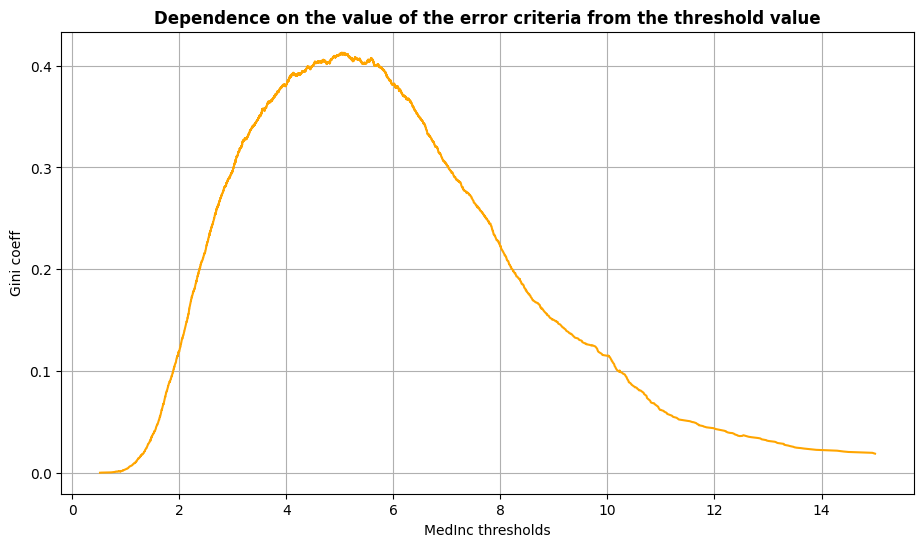

In [34]:
plt.figure(figsize=(11, 6))
plt.plot(thresholds, ginis, color='orange')
plt.xlabel('MedInc thresholds')
plt.ylabel('Gini coeff')
plt.title('Dependence on the value of the error criteria from the threshold value', fontweight='bold')
plt.grid()
plt.show()

Найдите лучший, с вашей точки зрения, предикат первой вершины решающего дерева.

In [35]:
best_feauture = None
best_inf_c = -10e10
best_t = None
for feature in X.columns: # будем искать по всем признакам
    t, inf_c = find_best_split(X[feature], y, task='regr')[-2:]
    if inf_c > best_inf_c:
        best_inf_c = inf_c
        best_feauture = feature
        best_t = t

print(f'{best_feauture} <= {best_t}')

MedInc <= 5.03515


**Задание 2.2 (1 балл)** Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод `_predict_node()`.

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции в разделе «Построение дерева».
- **Выбор лучшего разбиения** необходимо производить по критерию Джини.
- **Критерий останова:** все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку.
- **Ответ в листе:** наиболее часто встречающийся класс в листе.

В задаче также предлагается получить два бонуса, по баллу на каждый!

- **Реализуйте способ обрабатывать пропуски в даннх и реализуйте его, пояснив свои действия.**
- **Реализуйте метод оценки важности признаков.**

In [36]:
class DecisionTree:
    
    def __init__(
        self, 
        feature_types: Union[List[str], np.ndarray], 
        max_depth: int = None, 
        min_samples_split: int = None, 
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:
        
        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        # В этой переменной будем хранить узлы решающего дерева. Каждая вершина хранит в себе идентификатор того,
        # является ли она листовой. Листовые вершины хранят значение класса для предсказания, нелистовые - правого и
        # левого детей (поддеревья для продолжения процедуры предсказания)
        self._tree = {}
        
        # типы признаков (категориальные или числовые)
        self._feature_types = feature_types
        
        # гиперпараметры дерева
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task
        
        # Переменная, если вы решите делать бонус
        from collections import defaultdict
        self._feature_importances = defaultdict(float)
        

    def _fit_node(
        self, 
        sub_X: np.ndarray, 
        sub_y: np.ndarray, 
        node: dict,
        depth: int,
    ) -> None:
        
        # критерий останова
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        # регуляризация
        if self._max_depth is not None and depth >= self._max_depth:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        if self._min_samples_split is not None and sub_X.shape[0] < self._min_samples_split:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        # будем учитывать пропуски np.nan
        feature_best, thr_best, gini_best = None, None, -np.inf
        best_left_mask, best_nan_left = None, None

        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            feature_vector = sub_X[:, feature]

            # отделяем пропуски
            nan_mask = np.isnan(feature_vector)
            valid_mask = ~nan_mask
            if valid_mask.sum() == 0: # если все значения nan
                continue

            # ищем порог по не nan значениям
            _, _, threshold, gini = find_best_split(feature_vector[valid_mask], sub_y[valid_mask], self.task, feature_type)

            if threshold is None: # не удалось найти порог
                continue

            # маски не nan
            if feature_type == "real":
                left_valid = (feature_vector <= threshold) & valid_mask
            else: 
                left_valid = (feature_vector == threshold) & valid_mask
            right_valid = valid_mask & (~left_valid)

            # проверим куда отправлять nan
            gini_nan_left = information_criterion(sub_y, np.concatenate([sub_y[left_valid],  sub_y[nan_mask]]), sub_y[right_valid])
            gini_nan_right = information_criterion(sub_y, sub_y[left_valid], np.concatenate([sub_y[right_valid], sub_y[nan_mask]]))

            if gini_nan_left >= gini_nan_right:
                gini_candidate = gini_nan_left
                left_mask_total = left_valid | nan_mask # налево
                nan_left_flag = True
            else:
                gini_candidate = gini_nan_right
                left_mask_total = left_valid # направо
                nan_left_flag = False

            # обновляем лучший результат
            if gini_candidate > gini_best:
                gini_best = gini_candidate
                feature_best = feature
                thr_best = threshold
                best_left_mask = left_mask_total
                best_nan_left = nan_left_flag

        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        # min_samples_leaf
        left_mask = best_left_mask
        right_mask = ~left_mask
        if (self._min_samples_leaf is not None and (left_mask.sum() < self._min_samples_leaf or right_mask.sum() < self._min_samples_leaf)):
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        # пересчитываем важность
        self._feature_importances[feature_best] += gini_best

        node["type"] = "nonterminal"
        node["feature_split"] = feature_best
        node["missing_left"] = best_nan_left

        if self._feature_types[feature_best] == "real":
            node["threshold"] = thr_best
        else:
            node["category_split"] = thr_best

        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[left_mask],  sub_y[left_mask],  node["left_child"],  depth + 1)
        self._fit_node(sub_X[right_mask], sub_y[right_mask], node["right_child"], depth + 1)

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        """
        Предсказание начинается с корневой вершины дерева и рекурсивно идёт в левое или правое поддерево в зависимости от значения
        предиката на объекте. Листовая вершина возвращает предсказание.
        :param x: np.array, элемент выборки
        :param node: dict, вершина дерева
        """
        if node['type'] == 'terminal': return node['class']
        feature = node['feature_split']

        if np.isnan(x[feature]):
            if node['missing_left']:
                return self._predict_node(x, node['left_child'])
            else:
                return self._predict_node(x, node['right_child'])
        if self._feature_types[feature] == 'real':
            if x[feature] <= node['threshold']:
                return self._predict_node(x, node['left_child'])
            else:
                return self._predict_node(x, node['right_child'])
        elif self._feature_types[feature] == 'categorical':
            if x[feature] == node['category_split']:
                return self._predict_node(x, node['left_child'])
            else:
                return self._predict_node(x, node['right_child'])
        else:
            raise ValueError('Unknown feature type')


    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self._feature_importances.clear()
        self._fit_node(X, y, self._tree, 0)

        total = sum(self._feature_importances.values()) or 1.0
        self.feature_importances_ = np.zeros(len(self._feature_types))
        for f, val in self._feature_importances.items(): # нормируем
            self.feature_importances_[f] = val / total
        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))
            
        return np.array(predicted)

#### Куда отправить пропуски? в данной реализации: если отпрвить пропуски в левое поддерево выгоднее с точки зрения критерия информативности, то в левое, иначе в правое
#### Оценка важности признаков также реализована

**Задание 2.3 (1 балл)** Загрузите таблицу `students.csv` (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте диаграммы рассеяния "значение признака — класс" для всех пяти признаков.

In [37]:
students = pd.read_csv('students.csv', sep=',', index_col=0)

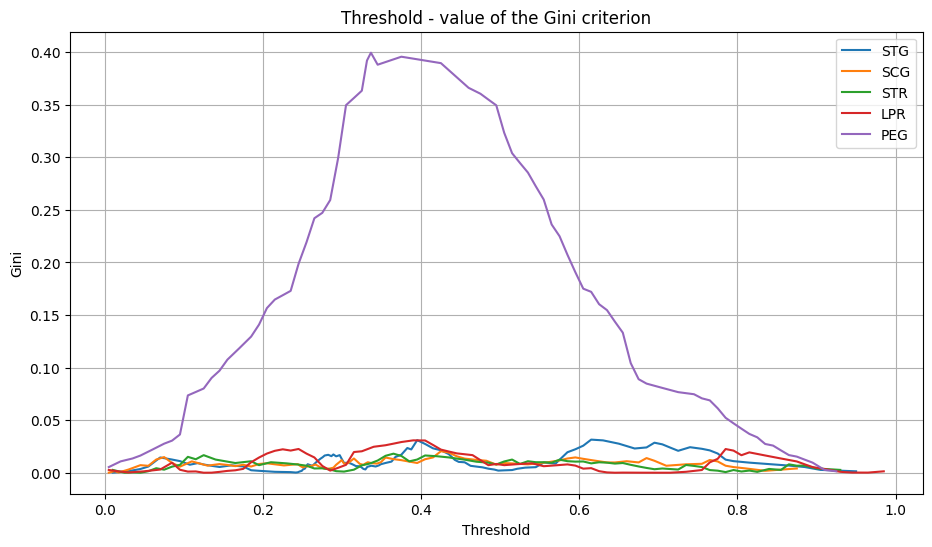

In [38]:
plt.figure(figsize=(11, 6))
for i in range(len(students.columns) - 1):
    thresholds, ginis = find_best_split(students[students.columns[i]], students[students.columns[-1]])[:2]
    plt.plot(thresholds, ginis, label=students.columns[i])
plt.ylabel('Gini')
plt.xlabel('Threshold')
plt.title('Threshold - value of the Gini criterion')
plt.grid()
plt.legend()
plt.show()

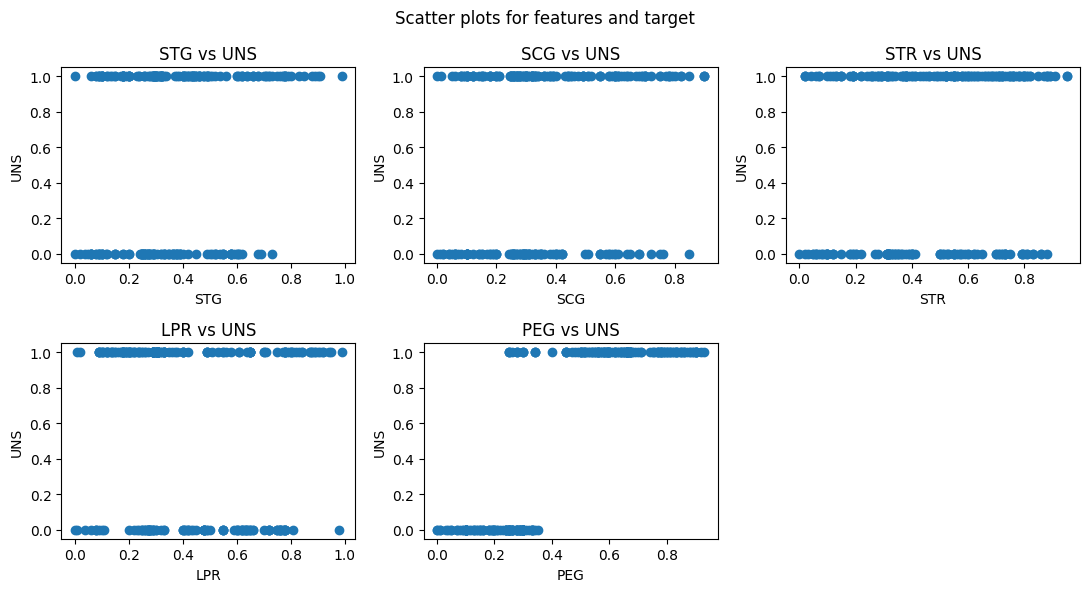

In [39]:
plt.figure(figsize=(11, 6))
plt.suptitle('Scatter plots for features and target')
for i, col in enumerate(students.columns[:-1]):
    plt.subplot(2, 3, i + 1)
    plt.scatter(students[col], students['UNS'])
    plt.xlabel(col)
    plt.ylabel('UNS')
    plt.title(f'{col} vs UNS')
plt.tight_layout()
plt.show()

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой диаграмм рассеяиния? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

#### Ответ:
Деление признаков на две группы стоит проводить по признаку `PEG` - разбиение по нему даёт наибольшую информативность. Это согласуется с диаграммами рассеяния, можно провести вертикальную линию между 0.2 и 0.4, почти идеально отделив единицы от нулей. Для хороших признаков на диаграмме рассеяния верхние точки (в нашем случае 1) будут минимально "накрывать" нижние (в нашем случае 0). 

**Задание 2.4 (1 балл)** Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). 

1. Скачайте таблицу `agaricus-lepiota.data` (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)), 
2. Считайте таблицу при помощи `pandas`,
3. Примените к каждому столбцу `LabelEncoder` (из `sklearn`), чтобы преобразовать строковые имена категорий в натуральные числа. 

Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

In [40]:
agaricus = pd.read_csv('agaricus-lepiota.data', sep=',')

In [41]:
from sklearn.model_selection import train_test_split

X_agaricus = agaricus.drop('p', axis=1)
y_agaricus = agaricus['p'].apply(lambda x: 1 if x == 'e' else 0)

X_train_agaricus, X_test_agaricus, y_train_agaricus, y_test_agaricus = train_test_split(X_agaricus, y_agaricus, test_size=0.5, random_state=42)

In [42]:
from sklearn.preprocessing import LabelEncoder
for column in X_train_agaricus.columns:
    le = LabelEncoder()
    X_train_agaricus[column] = le.fit_transform(X_train_agaricus[column])
    X_test_agaricus[column] = le.transform(X_test_agaricus[column])

In [43]:
dt = DecisionTree(feature_types=['categorical'] * X_train_agaricus.shape[1], task='classification').fit(X_train_agaricus.values, y_train_agaricus.values)
y_pred_agaricus = dt.predict(X_test_agaricus.values)

In [44]:
from sklearn.metrics import accuracy_score
print(f'Accuracy on test set: {accuracy_score(y_test_agaricus, y_pred_agaricus):.2f}')

Accuracy on test set: 1.00


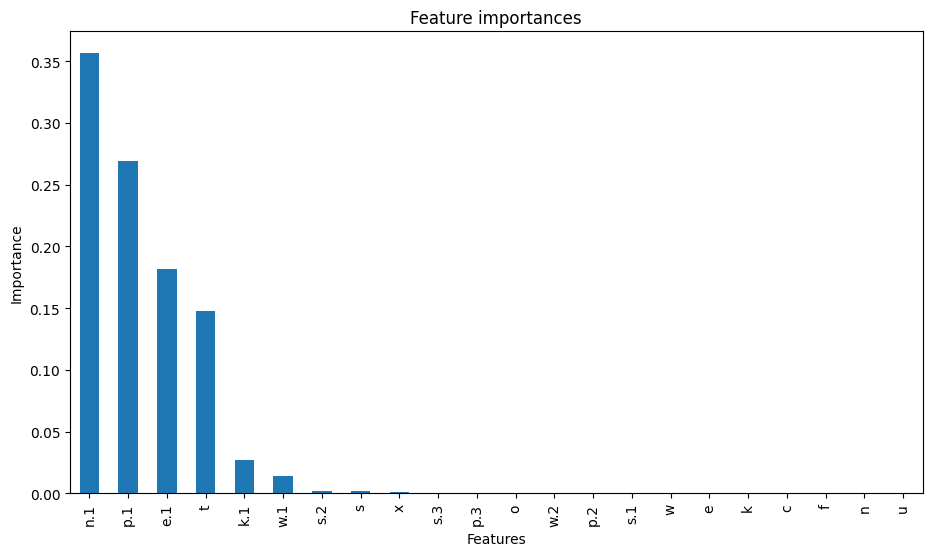

In [45]:
importances = pd.Series(dt.feature_importances_, index=X_train_agaricus.columns)
importances.sort_values(ascending=False, inplace=True)
plt.figure(figsize=(11, 6))
importances.plot(kind='bar')
plt.title('Feature importances')
plt.ylabel('Importance')
plt.xlabel('Features')
plt.show()

## Часть 3: Бэггинг и случайный лес (4 балла)

В данной части мы будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [46]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [47]:
data = pd.read_csv('diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

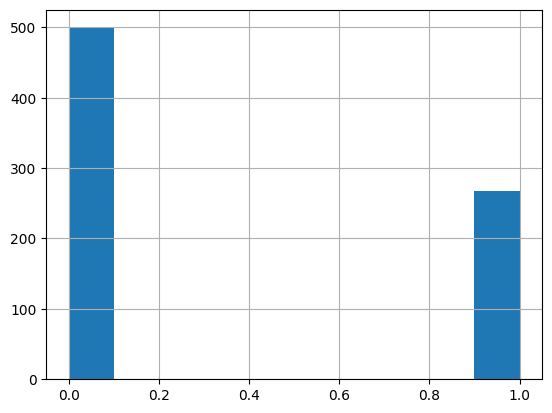

In [48]:
data['Outcome'].hist()
plt.show()

**Задание 3.1 (0.5 балла)** Разделите данные на признаки и целевую переменную. Разбейте датасет на обучающую и тестовую части в отношении 7:3. Затем разделите обучающую выборку на обучающую-обучающую и обучающую-валидационную в соотношении 7:3 (то есть в итоге должно получиться три выборки: обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета).

In [49]:
y = data['Outcome']
X = data.drop('Outcome', axis=1)

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123, stratify=y, test_size=0.3)

In [51]:
X_train, X_train_val, y_train, y_train_val = train_test_split(X_train, y_train, random_state=123, stratify=y_train, test_size=0.3)

**Задание 3.2 (1 балл)** На обучающей-валидационной выборке подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`. Для этого:
1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений обучите дерево на обучающей-обучающей выборке и определите качество на обучающей-валидационной выборке. В качестве критерия будем использовать `f1-меру`.
3. Выберите ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке. 


Обучите решающее дерево с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [52]:
max_depths = np.arange(1, 15, 1)
min_samples_leafs = np.arange(1, 30, 1)

In [53]:
from sklearn.metrics import f1_score

In [54]:
best_f1 = -10e10
best_max_depth, best_min_samples_leaf = None, None
for max_depth in max_depths:
    for min_samples_leaf in min_samples_leafs:
        f1 = f1_score(DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=123).fit(X_train, y_train).predict(X_train_val), y_train_val)
        if f1 > best_f1:
            best_f1 = f1
            best_max_depth = max_depth
            best_min_samples_leaf = min_samples_leaf
print(f'best_max_depth: {best_max_depth}, best_min_samples_leaf: {best_min_samples_leaf}')

best_max_depth: 5, best_min_samples_leaf: 17


In [55]:
dt = DecisionTreeClassifier(max_depth=best_max_depth, min_samples_leaf=best_min_samples_leaf, random_state=123).fit(X_train, y_train)
preds = dt.predict(X_test)
print(f'accuracy_score: {accuracy_score(y_test, preds):.2f}')
print(f'precision_score: {precision_score(y_test, preds):.2f}')
print(f'recall_score: {recall_score(y_test, preds):.2f}')
print(f'roc_auc_score: {roc_auc_score(y_test, preds):.2f}')

accuracy_score: 0.71
precision_score: 0.57
recall_score: 0.73
roc_auc_score: 0.72


**Задание 3.3 (0.5 балла)** Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по тем же метрикам.

In [56]:
bc = BaggingClassifier(n_estimators=50, n_jobs=-1, random_state=123).fit(X_train, y_train)
preds = bc.predict(X_test)
print(f'accuracy_score: {accuracy_score(y_test, preds):.2f}')
print(f'precision_score: {precision_score(y_test, preds):.2f}')
print(f'recall_score: {recall_score(y_test, preds):.2f}')
print(f'roc_auc_score: {roc_auc_score(y_test, preds):.2f}')

accuracy_score: 0.73
precision_score: 0.64
recall_score: 0.53
roc_auc_score: 0.69


**Задание 3.4 (1 балл)** Выполните кросс-валидацию на полной обучающей выборке и подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями. Для этого:

1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений проведите кросс-валидацию на полной обучающей выборке. Количество разбиений выберите на ваш вкус. В качестве критерия будем использовать `f1-меру`. Усредните значение критерия по всем прогонам кросс-валидации. 
3. Выберите ту пару значений, которая даёт наилучшее среднее качество. 

Обучите случайный лес с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации по тем же метрикам. Какая из трёх построенных моделей показала себя лучше?

In [57]:
max_depths = np.arange(1, 21, 1)
min_samples_splits = np.arange(2, 21, 1)

In [58]:
from sklearn.model_selection import cross_validate

In [59]:
best_score = -10e10
best_max_depth, best_min_samples_split = None, None

for max_depth in max_depths:
    for min_samples_split in min_samples_splits:
        scores = np.mean((cross_validate(
            RandomForestClassifier(n_estimators=50, max_depth=max_depth, min_samples_split=min_samples_split, n_jobs=-1, random_state=123),
            X=X_train, y=y_train, scoring='f1', n_jobs=-1, cv=5)['test_score']))
        if scores > best_score:
            best_score = scores
            best_min_samples_split = min_samples_split
            best_max_depth = max_depth

In [60]:
rf = RandomForestClassifier(n_estimators=50, max_depth=best_max_depth, min_samples_split=best_min_samples_split, random_state=123).fit(X_train, y_train)
preds = bc.predict(X_test)
print(f'accuracy_score: {accuracy_score(y_test, preds):.2f}')
print(f'precision_score: {precision_score(y_test, preds):.2f}')
print(f'recall_score: {recall_score(y_test, preds):.2f}')
print(f'roc_auc_score: {roc_auc_score(y_test, preds):.2f}')

accuracy_score: 0.73
precision_score: 0.64
recall_score: 0.53
roc_auc_score: 0.69


#### Бэггинг и случайный лесь вообще получились одинаковыми. В данном случае модели вообще слабо отличаются друг от друга (кроме метрики recall). Нельзя однозначно сказать как модель лучше - зависит от типа задачи, цены ошибки и других факторов. Все модели достаточно неплохого качества.

**Задание 3.5 (0.5 балла)** Постройте график зависимости AUC ROC на тестовой выборке от числа деревьев (`n_estimators`) для случайного леса, обучаемого на **полной обучающей** выборке. Какие выводы можно сделать?

In [61]:
aucs = []
n_estimators = np.arange(2, 201, 1)
for n in n_estimators:
    aucs.append(roc_auc_score(y_test, RandomForestClassifier(n_estimators=n).fit(X_train, y_train).predict(X_test)))

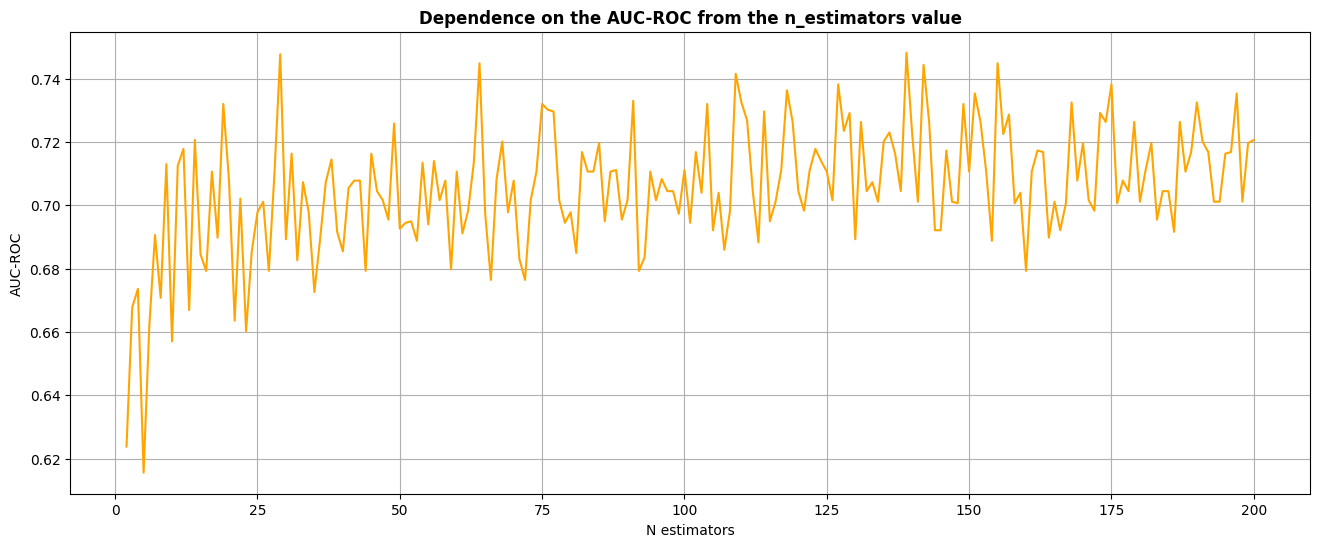

In [62]:
plt.figure(figsize=(16, 6))
plt.plot(n_estimators, aucs, color='orange')
plt.title('Dependence on the AUC-ROC from the n_estimators value', fontweight='bold')
plt.xlabel('N estimators')
plt.ylabel('AUC-ROC')
plt.grid()
plt.show()

#### При увелечении числа моделей в ансамбле качество не изменяется ни в худшую, ни в лучшую сторону. Это известный факт про данный гиперпараметр случайного леса, поэтому его можно сразу брать побольше - обычно хуже не ставновится (разве что только с точки зрения производительности).

**Задание 3.6 (0.5 балла)** Для лучшей модели случайного леса из **Задания 3.4** посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

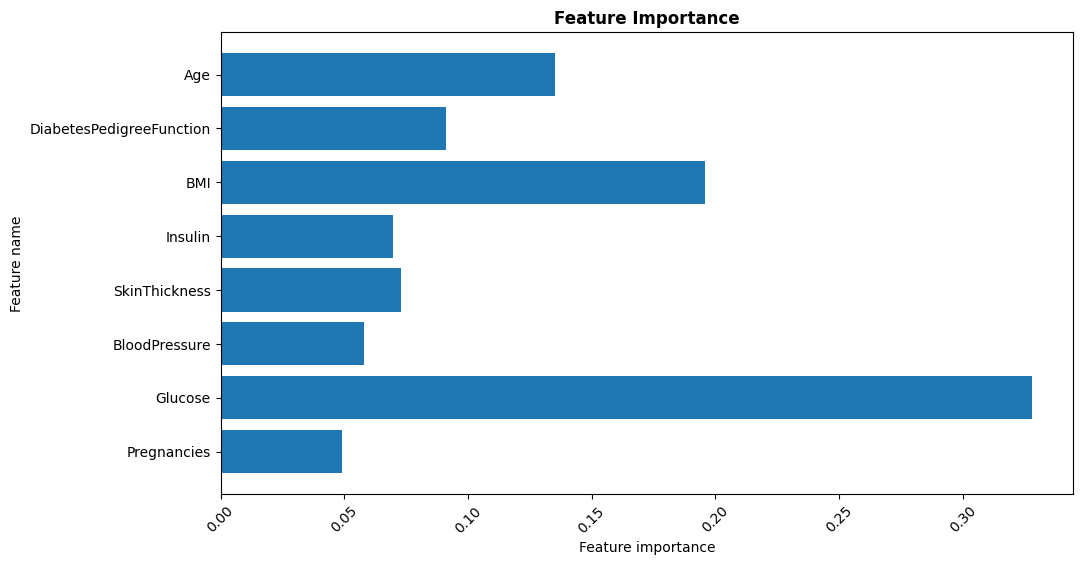

In [63]:
plt.figure(figsize=(11, 6))
plt.barh(rf.feature_names_in_, rf.feature_importances_)
plt.title('Feature Importance', fontweight='bold')
plt.xlabel('Feature importance')
plt.ylabel('Feature name')
plt.xticks(rotation=45)
plt.show()

#### Самым важным признком при выявляении диабета оказался уровень глюкозы - логично.